This notebook shows ion temperature diagnostics using the EIS instrumental width cross-calibrated with SUMER. 
Links to [Figure 9](#figure9) and [Figure 14](#figure14). 

(The internal hyperlink only works on [nbviewer](https://nbviewer.org/github/yjzhu-solar/EIS_SUMER_PCH_Ti/blob/main/ipynb/paper/temp_diag_v2_cross.ipynb). Do not click when viewing the notebook on GitHub.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import transforms
import astropy.constants as const
import pandas as pd
import cmcrameri.cm as cmcm
from matplotlib import rcParams
from scipy.ndimage.filters import gaussian_filter1d
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage[T1]{fontenc} \usepackage{amsmath} \usepackage{color}'
rcParams['font.family'] = 'serif'
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.width'] = 1.2
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.width'] = 1.2
rcParams['xtick.minor.size'] = 6
rcParams['ytick.major.width'] = 1.2
rcParams['ytick.major.size'] = 8
rcParams['ytick.minor.width'] = 1.2
rcParams['ytick.minor.size'] = 6 


In [2]:
df = pd.read_excel("../../save/eis_sumer_ion_width_merg_v3_cross.xlsx")
df["ion"] = df["ion"].str.strip()
df["charge"] = df["charge"].str.strip()
df["inst"] = df["inst"].str.strip()
df["quality"] = df["quality"].str.strip()
df

,ion,charge,Z,A,temp,inst,veff,veff_err,quality,desc
0,Fe,viii,7,55.85000,5.8,EIS,43.0,1.5,a,NaN
1,Fe,ix,8,55.85000,5.8,EIS,46.3,0.7,a,NaN
2,Fe,x,9,55.85000,5.9,EIS,47.4,0.9,a,NaN
3,Fe,xi,10,55.85000,6.0,EIS,48.1,0.3,a,NaN
4,Fe,xii,11,55.85000,6.1,EIS,49.8,1.8,a,NaN
5,Fe,xiii,12,55.85000,6.1,EIS,47.4,1.8,a,NaN
6,O,vi,5,15.99940,5.6,EIS,50.3,1.9,a,NaN
7,Mg,vi,5,24.30500,5.7,EIS,41.3,11.4,b,NaN
8,Mg,vii,6,24.30500,5.8,EIS,43.1,2.9,a,NaN
9,Si,vii,6,28.08550,5.8,EIS,43.7,0.2,a,NaN


In [3]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value
hplanck = const.h.cgs.value

In [4]:
line_name = df["ion"] + r" \textsc{"+ df["charge"] + r"}"
veff = df["veff"]*1.e5
veff_err = df["veff_err"]*1.e5
vnt_max = np.min(veff)
veff_res = np.sqrt(np.square(veff)-np.square(vnt_max)) + 1.
veff_res_err = np.sqrt(np.square(veff-veff_err)-np.square(vnt_max))
veff_res_err = np.nan_to_num(veff_res_err,nan=1.)
T_max = np.square(veff)*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_min = np.square(veff_res)*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_err = 2*veff*veff_err*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_min_err = veff*veff_err/veff_res*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_max_lim = T_max + T_err
T_min_lim = T_min - T_err
T_min_lim[T_min_lim <=0] = 1


/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df["T_max"] = T_max
df["T_min"] = T_min
df["T_err"] = T_err
df["T_max_lim"] = T_max_lim
df["T_min_lim"] = T_min_lim
df["Z2A"] = df["Z"]/df["A"]
df["label"] = df["ion"] + r" \textsc{"+ df["charge"] + r"}"

In [6]:
df

,ion,charge,Z,A,temp,inst,veff,veff_err,quality,desc,T_max,T_min,T_err,T_max_lim,T_min_lim,Z2A,label
0,Fe,viii,7,55.85000,5.8,EIS,43.0,1.5,a,NaN,6.210062e+06,2.727727e+06,4.332601e+05,6.643322e+06,2.294467e+06,0.125336,Fe \textsc{viii}
1,Fe,ix,8,55.85000,5.8,EIS,46.3,0.7,a,NaN,7.199809e+06,3.717475e+06,2.177048e+05,7.417514e+06,3.499770e+06,0.143241,Fe \textsc{ix}
2,Fe,x,9,55.85000,5.9,EIS,47.4,0.9,a,NaN,7.545981e+06,4.063646e+06,2.865562e+05,7.832537e+06,3.777090e+06,0.161146,Fe \textsc{x}
3,Fe,xi,10,55.85000,6.0,EIS,48.1,0.3,a,NaN,7.770503e+06,4.288169e+06,9.692936e+04,7.867433e+06,4.191240e+06,0.179051,Fe \textsc{xi}
4,Fe,xii,11,55.85000,6.1,EIS,49.8,1.8,a,NaN,8.329476e+06,4.847142e+06,6.021308e+05,8.931607e+06,4.245011e+06,0.196956,Fe \textsc{xii}
5,Fe,xiii,12,55.85000,6.1,EIS,47.4,1.8,a,NaN,7.545981e+06,4.063646e+06,5.731124e+05,8.119093e+06,3.490534e+06,0.214861,Fe \textsc{xiii}
6,O,vi,5,15.99940,5.6,EIS,50.3,1.9,a,NaN,2.434308e+06,1.436720e+06,1.839040e+05,2.618212e+06,1.252816e+06,0.312512,O \textsc{vi}
7,Mg,vi,5,24.30500,5.7,EIS,41.3,11.4,b,NaN,2.493053e+06,9.775985e+05,1.376310e+06,3.869363e+06,1.000000e+00,0.205719,Mg \textsc{vi}
8,Mg,vii,6,24.30500,5.8,EIS,43.1,2.9,a,NaN,2.715101e+06,1.199646e+06,3.653732e+05,3.080474e+06,8.342731e+05,0.246863,Mg \textsc{vii}
9,Si,vii,6,28.08550,5.8,EIS,43.7,0.2,a,NaN,3.225380e+06,1.474205e+06,2.952293e+04,3.254903e+06,1.444682e+06,0.213633,Si \textsc{vii}


In [7]:
df_sumer = df.loc[df["inst"] == "SUMER"]
df_eis = df.loc[df["inst"] == "EIS"]
stats_sumer = []
pos_sumer = []
stats_eis = []
pos_eis = []

for ii, row in df_sumer.iterrows():
    label = dict(
        q1=row["T_min"],
        q3=row["T_max"],
        whislo=row["T_min_lim"],
        whishi=row["T_max_lim"],
        mean=0,iqr=0,cilo=0,cihi=0,fliers=np.array([]),med=0
    )
    stats_sumer.append(label)
    pos_sumer.append(row["Z2A"])

for ii, row in df_eis.iterrows():
    label = dict(
        q1=row["T_min"],
        q3=row["T_max"],
        whislo=row["T_min_lim"],
        whishi=row["T_max_lim"],
        mean=0,iqr=0,cilo=0,cihi=0,fliers=np.array([]),med=0
    )
    stats_eis.append(label)
    pos_eis.append(row["Z2A"])

In [8]:
def rainbow_text(ax,x,y,ls,lc,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    """
    t = plt.gca().transData

    #horizontal version
    for s,c in zip(ls,lc):
        text = ax.text(x,y,s,color=c, transform=t, **kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

    #vertical version
    # for s,c in zip(ls,lc):
    #     text = ax.text(x,y,s+" ",color=c, transform=t,
    #             rotation=90,va='bottom',ha='center',**kw)
    #     text.draw(fig.canvas.get_renderer())
    #     ex = text.get_window_extent()
    #     t = transforms.offset_copy(text._transform, y=ex.height, units='dots')

Text(0.5, 0, 'Charge to Mass Ratio $Z/A$')

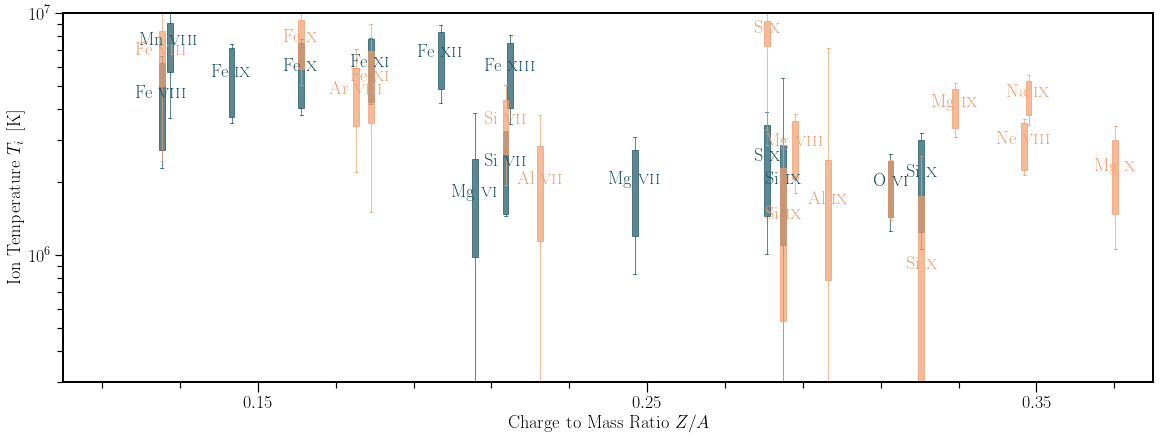

In [9]:
color_sumer = cmcm.batlow(0.75)
color_eis = cmcm.batlow(0.2)
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
eis_boxprops = dict(edgecolor=color_eis,facecolor=color_eis,alpha=0.7)
eis_capprops = dict(color=color_eis,alpha=0.7)
eis_whiskerprops = dict(color=color_eis,alpha=0.7)

sumer_boxprops = dict(edgecolor=color_sumer,facecolor=color_sumer,alpha=0.7)
sumer_capprops = dict(color=color_sumer,alpha=0.7)
sumer_whiskerprops = dict(color=color_sumer,alpha=0.7)

medianprops= dict(linewidth=0)

ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

for ii, row in df_sumer.iterrows():
    ax.text(row["Z2A"],(row["T_min"]+row["T_max"])/2,row["label"],fontsize=18,color=color_sumer,
        ha="center")

for ii, row in df_eis.iterrows():
    ax.text(row["Z2A"],(row["T_min"]+row["T_max"])/2,row["label"],fontsize=18,color=color_eis,
        ha="center")
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.1,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"Ion Temperature $T_i\ \left[\mathrm{K}\right]$",fontsize=18)
ax.set_xlabel(r"Charge to Mass Ratio $Z/A$",fontsize=18)

Text(0.02, 0.03, '\\textbf{*}$\\boldsymbol{\\Delta \\lambda_{\\rm inst, EIS} = 62.7\\,\\mathrm{m}}$\\textbf{\\mbox{\\AA}}')

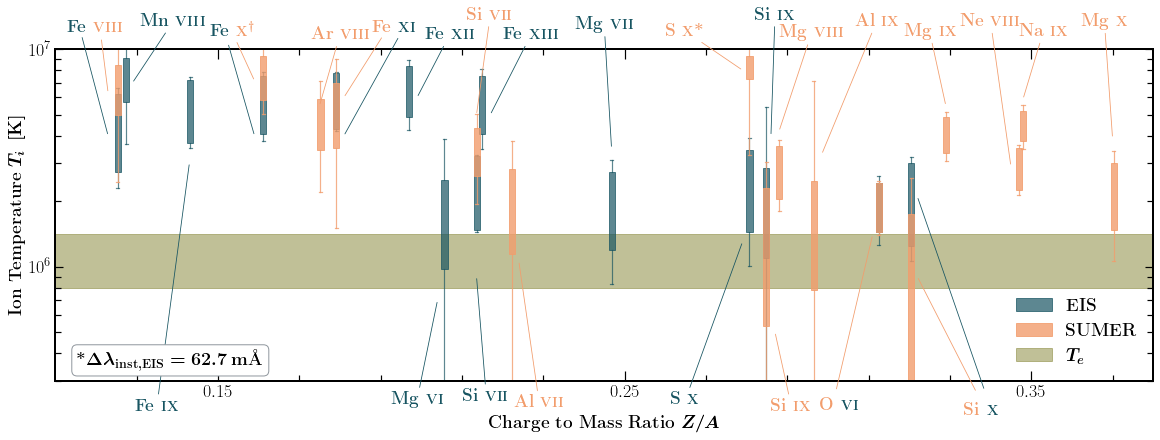

In [10]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
eis_boxprops = dict(edgecolor=color_eis,facecolor=color_eis,alpha=0.7)
eis_capprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)
eis_whiskerprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)

sumer_boxprops = dict(edgecolor=color_sumer,facecolor=color_sumer,alpha=0.8)
sumer_capprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)
sumer_whiskerprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)

medianprops= dict(linewidth=0)

eis_bp = ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

sumer_bp = ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

eis_xycoords = [(0.123,4e6),(0.143,3e6),(0.159,4e6),(0.129,7e6),
                (0.181,4e6),(0.199,6e6),(0.204,7e5),(0.2136,9e5),(0.217,5e6),
                (0.2468,3.5e6),(0.279,1.3e6),(0.286,4e6),(0.322,2.1e6)]
eis_textcoords = [(0.116,1.05),(0.135,-0.09),(0.152,1.025),(0.139,1.07),
                (0.195,1.035),(0.207,1.03),(0.199,-0.07),(0.216,-0.06),(0.227,1.03),
                (0.245,1.06),(0.265,-0.07),(0.287,1.09),(0.339,-0.06)]
eis_texts = [r"",r"Fe \textsc{ix}",r"",r"Mn \textsc{viii}",
            r"",r"Fe \textsc{xii}",r"Mg \textsc{vi}",r"Si \textsc{vii}",r"Fe \textsc{xiii}",
            r"Mg \textsc{vii}",r"S \textsc{x}",r"Si \textsc{ix}",r""]

for ii, text_ in enumerate(eis_texts):
    ax.annotate(r"\textbf{" + text_ + "}",eis_xycoords[ii],eis_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_eis,ha="center",arrowprops=dict(edgecolor=color_eis,arrowstyle="-",lw=0.8))

sumer_xycoords = [(0.123,6.3e6),(0.159,7.15e6),(0.175,5.5e6),(0.181,6e6),(0.2136,5e6),
                (0.224,1.06e6),(0.279,8e6),(0.287,5e5),(0.288,4.2e6),(0.2985,3.29e6),
                (0.311,1.4e6),(0.322,9e5),(0.329,5.5e6),(0.345,2.9e6),(0.348,5.9e6),
                (0.37,3.9e6)]
sumer_textcoords = [(0.121,1.05),(0.154,1.025),(0.18,1.03),(0.191,1.035),(0.217,1.09),
                (0.229,-0.08),(0.265,1.04),(0.291,-0.09),(0.296,1.035),(0.312,1.07),
                (0.3015,-0.07),(0.337,-0.06),(0.325,1.04),(0.34,1.07),(0.353,1.04),
                (0.368,1.07)]
sumer_texts = [r"","",r"Ar \textsc{viii}",r"",r"Si \textsc{vii}",
                r"Al \textsc{vii}",r"S \textsc{x}*",r"Si \textsc{ix}",r"Mg \textsc{viii}",r"Al \textsc{ix}",
                r"",r"",r"Mg \textsc{ix}",r"Ne \textsc{viii}",r"Na \textsc{ix}",
                r"Mg \textsc{x}"]

for ii, text_ in enumerate(sumer_texts):
    ax.annotate(r"\textbf{"+text_+"}",sumer_xycoords[ii],sumer_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_sumer,ha="center",arrowprops=dict(edgecolor=color_sumer,arrowstyle="-",lw=0.8))

rainbow_text(ax,0.113,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{viii}}"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.148,1.15e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{x}}$\boldsymbol{^\dagger}$"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.188,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{xi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.298,2.2e5,[r"\textbf{O}",r"t",r"\textbf{\textsc{vi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.3335,2.1e5,[r"\textbf{Si}",r"t",r"\textbf{\textsc{x}}"],[color_sumer,"white",color_eis],fontsize=18)

te_hspan = ax.axhspan(10**5.9,10**6.15,color=cmcm.batlow(0.5),alpha=0.5,zorder=0)
ax.legend([eis_bp["boxes"][0],sumer_bp["boxes"][0],te_hspan],[r"\textbf{EIS}",r"\textbf{SUMER}",r"$\boldsymbol{T_e}$"],loc="lower right",fontsize=18,frameon=False)
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.11,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18,direction="in",which="both",right=True,top=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"\textbf{Ion Temperature} $\boldsymbol{T_i\ \left[\mathrm{K}\right]}$",fontsize=18)
ax.set_xlabel(r"\textbf{Charge to Mass Ratio} $\boldsymbol{Z/A}$",fontsize=18,labelpad=15)
ax.text(0.02,0.03,r"\textbf{*}$\boldsymbol{\Delta \lambda_{\rm inst, EIS} = 62.7\,\mathrm{m}}$\textbf{\mbox{\AA}}",transform=ax.transAxes,
        ha="left",va="bottom",color="black",fontsize=18,bbox=dict(boxstyle="round", fc="w",ec="#91989F"))
#ax.grid("on",which="both")
# plt.savefig(fname="../../figs/ms/temp_diag_cross.pdf",format="pdf")

### Figure 9
<a id='figure9'></a>

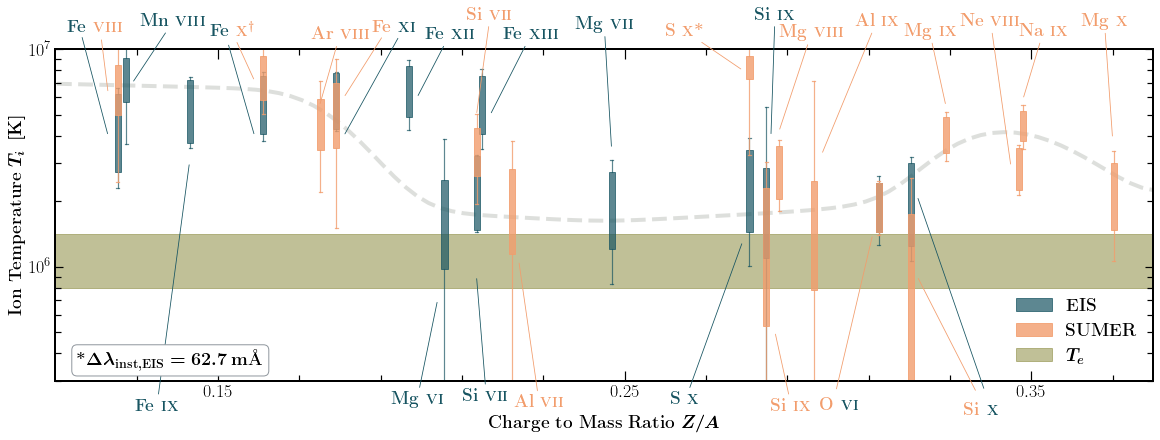

In [11]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)

eis_boxprops = dict(edgecolor=color_eis,facecolor=color_eis,alpha=0.7)
eis_capprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)
eis_whiskerprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)

sumer_boxprops = dict(edgecolor=color_sumer,facecolor=color_sumer,alpha=0.8)
sumer_capprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)
sumer_whiskerprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)

medianprops= dict(linewidth=0)

eis_bp = ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

sumer_bp = ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

bg_curve_x = np.array([0.1,0.17,0.195,0.245,0.295,0.32,0.33,0.347,0.38])
bg_curve_y = np.array([7e6,6.5e6,1.8e6,1.6e6,1.8e6,2e6,4e6,4.5e6,1.8e6])
bg_curve_x_interp = np.linspace(0.1,0.38,100)
bg_curve_y_interp = np.interp(bg_curve_x_interp,bg_curve_x, bg_curve_y)
bg_smooth = gaussian_filter1d(bg_curve_y_interp,sigma=3)
ax.plot(bg_curve_x_interp, bg_smooth,zorder=0,lw=4,ls='--',color="#BDC0BA",alpha=0.5)

for ii, text_ in enumerate(eis_texts):
    ax.annotate(r"\textbf{" + text_ + "}",eis_xycoords[ii],eis_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_eis,ha="center",arrowprops=dict(edgecolor=color_eis,arrowstyle="-",lw=0.8))


for ii, text_ in enumerate(sumer_texts):
    ax.annotate(r"\textbf{"+text_+"}",sumer_xycoords[ii],sumer_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_sumer,ha="center",arrowprops=dict(edgecolor=color_sumer,arrowstyle="-",lw=0.8))

rainbow_text(ax,0.113,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{viii}}"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.148,1.15e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{x}}$\boldsymbol{^\dagger}$"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.188,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{xi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.298,2.2e5,[r"\textbf{O}",r"t",r"\textbf{\textsc{vi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.3335,2.1e5,[r"\textbf{Si}",r"t",r"\textbf{\textsc{x}}"],[color_sumer,"white",color_eis],fontsize=18)

te_hspan = ax.axhspan(10**5.9,10**6.15,color=cmcm.batlow(0.5),alpha=0.5,zorder=0)
ax.legend([eis_bp["boxes"][0],sumer_bp["boxes"][0],te_hspan],[r"\textbf{EIS}",r"\textbf{SUMER}",r"$\boldsymbol{T_e}$"],loc="lower right",fontsize=18,frameon=False)
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.11,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18,direction="in",which="both",right=True,top=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"\textbf{Ion Temperature} $\boldsymbol{T_i\ \left[\mathrm{K}\right]}$",fontsize=18)
ax.set_xlabel(r"\textbf{Charge to Mass Ratio} $\boldsymbol{Z/A}$",fontsize=18,labelpad=15)
ax.text(0.02,0.03,r"\textbf{*}$\boldsymbol{\Delta \lambda_{\rm inst, EIS} = 62.7\,\mathrm{m}}$\textbf{\mbox{\AA}}",transform=ax.transAxes,
        ha="left",va="bottom",color="black",fontsize=18,bbox=dict(boxstyle="round", fc="w",ec="#91989F"))
# plt.savefig(fname="../../figs/ms/temp_diag_cross_ushape.png",format="png")
plt.savefig(fname="../../figs/ms/temp_diag_cross.pdf",format="pdf")

In [12]:
df_sort_Z2A = df.sort_values("Z2A")

In [13]:
for index, row in df_sort_Z2A.iterrows():
    print(row["label"],"{:.3f}".format(row["Z2A"]),"T_min","{:.2f} {:.2f} {:.2f}".format(np.log10(row["T_min"]), np.log10(row["T_min"] + row["T_err"]) - np.log10(row["T_min"]),  np.log10(row["T_min"]) - np.log10(row["T_min"] - row["T_err"])))
    print(row["label"],"{:.3f}".format(row["Z2A"]),"T_max","{:.2f} {:.2f} {:.2f}".format(np.log10(row["T_max"]), np.log10(row["T_max"] + row["T_err"]) - np.log10(row["T_max"]),  np.log10(row["T_max"]) - np.log10(row["T_max"] - row["T_err"])))

Fe \textsc{viii} 0.125 T_min 6.44 0.06 0.08
Fe \textsc{viii} 0.125 T_max 6.79 0.03 0.03
Fe \textsc{viii} 0.125 T_min 6.70 0.18 0.31
Fe \textsc{viii} 0.125 T_max 6.93 0.11 0.15
Mn \textsc{viii} 0.127 T_min 6.75 0.13 0.19
Mn \textsc{viii} 0.127 T_max 6.96 0.09 0.11
Fe \textsc{ix} 0.143 T_min 6.57 0.02 0.03
Fe \textsc{ix} 0.143 T_max 6.86 0.01 0.01
Fe \textsc{x} 0.161 T_min 6.61 0.03 0.03
Fe \textsc{x} 0.161 T_max 6.88 0.02 0.02
Fe \textsc{x} 0.161 T_min 6.77 0.06 0.07
Fe \textsc{x} 0.161 T_max 6.97 0.04 0.04
Ar \textsc{viii} 0.175 T_min 6.53 0.13 0.19
Ar \textsc{viii} 0.175 T_max 6.77 0.08 0.10
Fe \textsc{xi} 0.179 T_min 6.63 0.01 0.01
Fe \textsc{xi} 0.179 T_max 6.89 0.01 0.01
Fe \textsc{xi} 0.179 T_min 6.54 0.20 0.37
Fe \textsc{xi} 0.179 T_max 6.84 0.11 0.15
Fe \textsc{xii} 0.197 T_min 6.69 0.05 0.06
Fe \textsc{xii} 0.197 T_max 6.92 0.03 0.03
Mg \textsc{vi} 0.206 T_min 5.99 0.38 nan
Mg \textsc{vi} 0.206 T_max 6.40 0.19 0.35
Si \textsc{vii} 0.214 T_min 6.42 0.10 0.13
Si \textsc{vii} 0.21

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df_landi = pd.read_excel("../../save/Tion_comp_landi_dolla.xlsx",sheet_name="landi")
df_landi

,ion,charge,wvl,Tmin,Tmid,Tmax,Z,A,Z2A
0,Fe,x,1028,6.63,6.82,6.95,9,55.85000,0.161146
1,Ar,viii,700,6.45,6.65,6.79,7,39.94800,0.175228
2,Fe,xi,1467,6.56,6.77,6.92,10,55.85000,0.179051
3,Fe,xii,1242,6.65,6.83,6.96,11,55.85000,0.196956
4,Si,vii,1049,6.06,6.37,6.54,6,28.08550,0.213633
5,Al,vii,1053,5.71,6.21,6.44,6,26.98154,0.222374
6,Al,vii,1056,5.97,6.31,6.50,6,26.98154,0.222374
7,Ca,x,557,6.39,6.62,6.76,9,40.08000,0.224551
8,Ca,x,574,6.38,6.61,6.76,9,40.08000,0.224551
9,Mg,vii,854,5.89,6.25,6.45,6,24.30500,0.246863


In [15]:
df_dolla = pd.read_excel("../../save/Tion_comp_landi_dolla.xlsx",sheet_name="dolla")
df_dolla

,ion,charge,wvl,Tion,Tion_err,Z,A,Z2A
0,Fe,x,1028,5.96,0.70,9,55.85000,0.161146
1,Fe,x,1463,4.87,1.15,9,55.85000,0.161146
2,Fe,xi,1467,3.64,0.62,10,55.85000,0.179051
3,Ar,viii,700,3.35,0.36,7,39.94800,0.175228
4,Ar,viii,713,2.88,0.34,7,39.94800,0.175228
5,Fe,xii,1242,3.34,0.50,11,55.85000,0.196956
6,Fe,xii,1349,2.98,0.45,11,55.85000,0.196956
7,Ca,x,574,3.43,0.42,9,40.08000,0.224551
8,Si,viii,1445,3.24,0.27,7,28.08550,0.249239
9,S,x,1196,3.23,0.35,9,32.06000,0.280724


In [16]:
df_ion_this = df[["ion","charge","Z2A"]]
df_ion_landi = df_landi[["ion","charge","Z2A"]]
df_ion_dolla = df_dolla[["ion","charge","Z2A"]]
df_ion = pd.concat([df_ion_this,df_ion_landi,df_ion_dolla],ignore_index=True)
df_ion = df_ion.drop_duplicates(subset=("ion","charge")).sort_values("Z2A").reset_index(drop=True)
df_ion

,ion,charge,Z2A
0,Fe,viii,0.125336
1,Mn,viii,0.127416
2,Fe,ix,0.143241
3,Fe,x,0.161146
4,Ar,viii,0.175228
5,Fe,xi,0.179051
6,Fe,xii,0.196956
7,Mg,vi,0.205719
8,Si,vii,0.213633
9,Fe,xiii,0.214861


### Figure 14
<a id='figure14'></a>

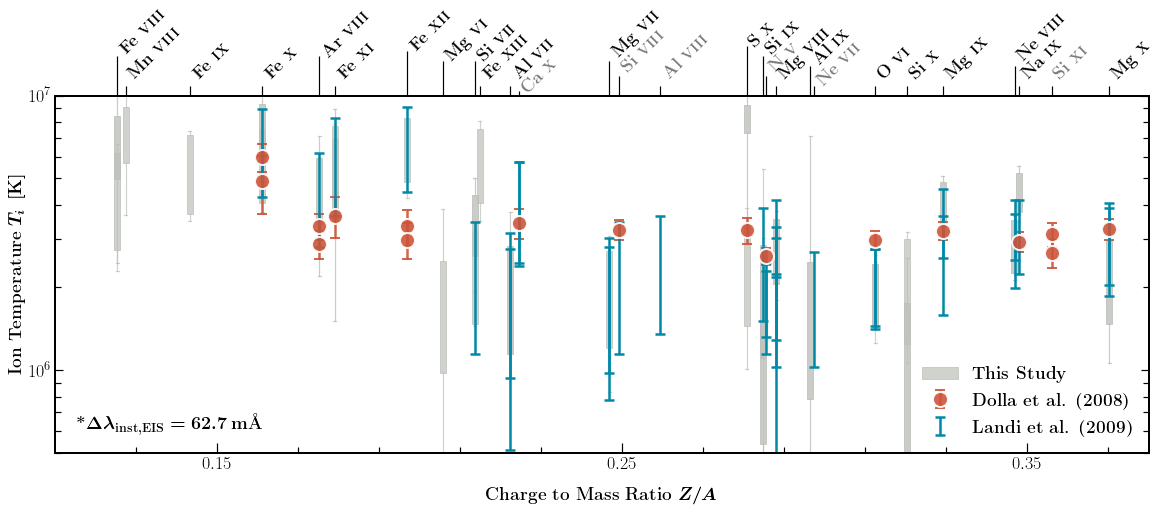

In [17]:
fig, ax = plt.subplots(figsize=(16,7),constrained_layout=True)
color_bg = "#BDC0BA"
eis_boxprops = dict(edgecolor=color_bg,facecolor=color_bg,alpha=0.7)
eis_capprops = dict(color=color_bg,alpha=0.7,linewidth=1.2)
eis_whiskerprops = dict(color=color_bg,alpha=0.7,linewidth=1.2)

sumer_boxprops = dict(edgecolor=color_bg,facecolor=color_bg,alpha=0.8)
sumer_capprops = dict(color=color_bg,alpha=0.8,linewidth=1.2)
sumer_whiskerprops = dict(color=color_bg,alpha=0.8,linewidth=1.2)

medianprops= dict(linewidth=0)

eis_bp = ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

sumer_bp = ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

ln_dolla = ax.errorbar(df_dolla["Z2A"],df_dolla["Tion"]*1e6,df_dolla["Tion_err"]*1e6,color="#CC543A",ls="none",marker="o",
            markersize=15,capsize=5,lw=2.5,label=r"\textbf{Dolla et al. (2008)}",zorder=15,markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5)

Tion_landi_max = np.power(10,df_landi["Tmax"])
Tion_landi_min = np.power(10,df_landi["Tmin"])
Tion_landi_mid = (Tion_landi_max + Tion_landi_min)/2
ln_landi = ax.errorbar(df_landi["Z2A"],Tion_landi_mid,Tion_landi_max - Tion_landi_mid,
            marker=None,fmt="none",capsize=5,lw=2.5,color = "#0089A7",label=r"\textbf{Landi et al. (2009)}",capthick=2.5,zorder=15)


ax.legend([eis_bp["boxes"][0],ln_dolla,ln_landi],
        [r"\textbf{This Study}",r"\textbf{Dolla et al. (2008)}",r"\textbf{Landi et al. (2009)}"],
        loc="lower right",fontsize=18,frameon=False)
ax.set_yscale("log")
ax.set_ylim(5e5,1e7)
ax.set_xlim(0.11,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18,direction="in",which="both",right=True,top=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"\textbf{Ion Temperature} $\boldsymbol{T_i\ \left[\mathrm{K}\right]}$",fontsize=18)
ax.set_xlabel(r"\textbf{Charge to Mass Ratio} $\boldsymbol{Z/A}$",fontsize=18,labelpad=15)
ax.text(0.02,0.05,r"\textbf{*}$\boldsymbol{\Delta \lambda_{\rm inst, EIS} = 62.7\,\mathrm{m}}$\textbf{\mbox{\AA}}",transform=ax.transAxes,
        ha="left",va="bottom",color="black",fontsize=18)

ion_name = r"\textbf{" + df_ion["ion"] + r" \textsc{"+ df_ion["charge"] + r"}}"
ax_ion = ax.twiny()
ax_ion.set_xlim(ax.get_xlim())
ax_ion.set_xticks(df_ion["Z2A"].values)
ax_ion.set_xticklabels(ion_name,rotation=45,ha="left")
ax_ion.tick_params(labelsize=18)

tick_len_index = [1,9,13,15,17,23,25,27,31,33,35,39,41,49]
tick_len = [40,40,45,35,35,5,35,20,50,40,20,30,10,30]
label_index = [0,4,6,7,8,11,12,13,15,16,17,19,20,24]
label_pos = [1.07,1.06,1.08,1.05,1.05,0.96,1.06,1.02,1.09,1.07,1.02,1.04,0.98,1.05]
not_this_study_label_index = [11,13,14,17,20,26]
ax_ion_major_ticks = ax_ion.get_xticklines()
ax_ion_major_labels = ax_ion.get_xmajorticklabels()
for tick_len_index_, tick_len_, label_index_, label_pos_ in zip(tick_len_index, tick_len, label_index, label_pos):
    ax_ion_major_ticks[tick_len_index_].set_markersize(tick_len_)
    ax_ion_major_labels[label_index_].set_y(label_pos_)
for label_index_ in not_this_study_label_index:
    ax_ion_major_labels[label_index_].set_color("#787878")
plt.savefig(fname="../../figs/ms/temp_landi_dolla.pdf",format="pdf",dpi=300)